In [4]:
# Reading EDF files requires the mne module 
import mne
import matplotlib.pyplot as plt
import numpy as np

The documentation of MNE can be found on [this web site](https://mne.tools) and more precisely [to read EDF files](https://mne.tools/dev/generated/mne.io.read_raw_edf.html). You also look at [this tutorial](https://mne.tools/dev/auto_tutorials/clinical/60_sleep.html#sphx-glr-auto-tutorials-clinical-60-sleep-py)


In the first section, the access to raw data is described. For the machine learning experiments, we will use already prepared files: subsampled, segments of 30s, all in numpy arrays. 


# Reading raw data

The dataset can be downloaded from this [link](https://www.physionet.org/content/sleep-edfx/1.0.0/). There is also a useful description on this page. All the data represents more than 8GB in their raw format. 

## Overview of the dataset
It gathers two datasets: Cassette and Telemetry. 

### Sleep Cassette Study and Data

The 153 `SC*` files (SC = Sleep Cassette) were obtained in a 1987-1991 study of age effects on sleep in healthy Caucasians aged 25-101, without any sleep-related medication. Two PSGs of about 20 hours each were recorded during two subsequent day-night periods at the subjects homes. Subjects continued their normal activities but wore a modified Walkman-like cassette-tape.
Files are named in the form `SC4ssNEO-PSG.edf` where `ss` is the subject number, and `N` is the night. 

### Sleep Telemetry Study and Data

The 44 `ST*` files (ST = Sleep Telemetry) were obtained in a 1994 study of temazepam effects on sleep in 22 Caucasian males and females without other medication. Subjects had mild difficulty falling asleep but were otherwise healthy. The PSGs of about 9 hours were recorded in the hospital during two nights, one of which was after temazepam intake, and the other of which was after placebo intake. Files are named in the form `ST7ssNJ0-PSG.edf` where `ss` is the subject number, and `N` is the night.


## Access to some raw files
If you just want to access to some raw files, the `mne` API allows you to fetch some files by providing a list of subjects like this:

In [5]:
from mne.datasets.sleep_physionet.age import fetch_data as sleep_casette
from mne.datasets.sleep_physionet.temazepam import fetch_data as sleep_telemetry


files_casette = sleep_casette(subjects=[12], recording=[1])

Using default location ~/mne_data for PHYSIONET_SLEEP...


In [6]:
files_telemetry = sleep_telemetry(subjects=[21])


Using default location ~/mne_data for PHYSIONET_SLEEP...


In [7]:
import requests
import os
import string

def download_file(filename, base_url, target_path):
    url = f"{base_url}/{filename}"
    response = requests.head(url)  # Check if the file exists
    if response.status_code == 200:
        full_path = os.path.join(target_path, filename)
        if not os.path.exists(full_path):
            print(f'Downloading from: {url}\nTo: {full_path}')
            with requests.get(url, stream=True) as r:
                r.raise_for_status()
                with open(full_path, 'wb') as f:
                    for chunk in r.iter_content(chunk_size=8192):
                        f.write(chunk)
            print('Download complete.')
        else:
            print('File already exists:', full_path)
        return full_path
    return None

def get_file(type_, subject, recording, base_path):
    config = {
        'sleep-telemetry': ("ST7", ['J'], '01', '24', '1', '2'),
        'sleep-cassette': ("SC4", ['E', 'F', 'G'], '00', '82', '1', '2')
    }

    if type_ not in config:
        raise ValueError('Invalid type')

    prefix, possible_letters, min_subject, max_subject, min_recording, max_recording = config[type_]
    print(f"Subject goes from '{min_subject}' to '{max_subject}' and recording goes from '{min_recording}' to '{max_recording}'")

    path = os.path.join(base_path, type_)
    os.makedirs(path, exist_ok=True)
    
    base_url = f'https://physionet.org/physiobank/database/sleep-edfx/{type_}'
    base_filename = f"{prefix}{subject}{recording}"
    downloaded_files = []

    # Download PSG file
    for letter in possible_letters:
        psg_filename = f"{base_filename}{letter}0-PSG.edf"
        psg_path = download_file(psg_filename, base_url, path)
        if psg_path:
            downloaded_files.append(psg_path)
            # Download corresponding Hypnogram file
            for letter2 in string.ascii_uppercase:
                hyp_filename = f"{base_filename}{letter}{letter2}-Hypnogram.edf"
                hyp_path = download_file(hyp_filename, base_url, path)
                if hyp_path:
                    downloaded_files.append(hyp_path)
                    break
            break

    return downloaded_files



In [8]:
# Example usage:
type_ = 'sleep-telemetry'
subject = '02'
recording = '1'
base_path = r'C:\Users\EstebanPapacitoRico\Documents\GitHub\DL_Project\org-data'

filename = get_file(type_, subject, recording, base_path)

Subject goes from '01' to '24' and recording goes from '1' to '2'
File already exists: C:\Users\EstebanPapacitoRico\Documents\GitHub\DL_Project\org-data\sleep-telemetry\ST7021J0-PSG.edf
File already exists: C:\Users\EstebanPapacitoRico\Documents\GitHub\DL_Project\org-data\sleep-telemetry\ST7021JM-Hypnogram.edf


In [9]:
print(filename)

['C:\\Users\\EstebanPapacitoRico\\Documents\\GitHub\\DL_Project\\org-data\\sleep-telemetry\\ST7021J0-PSG.edf', 'C:\\Users\\EstebanPapacitoRico\\Documents\\GitHub\\DL_Project\\org-data\\sleep-telemetry\\ST7021JM-Hypnogram.edf']


## Visualization 

Assume you downloaded some raw data files. 

In [10]:
# Look at Telemetry 
#datad="./org-data/sleep-edf-database-expanded-1.0.0/"
#file = datad+"sleep-telemetry/ST7011J0-PSG.edf"


# data = mne.io.read_raw_edf(files_casette[0][0], preload=True)
data = mne.io.read_raw_edf(filename[0], preload=True)
raw_data = data.get_data()
print("*** type=", type(raw_data), ", taille = ", raw_data.size, ", dims = ", raw_data.shape)
# You can get the metadata included in the file and a list of all channels:
print("*** info :", data.info)
print("*** channels :", data.ch_names)


Extracting EDF parameters from C:\Users\EstebanPapacitoRico\Documents\GitHub\DL_Project\org-data\sleep-telemetry\ST7021J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Reading 0 ... 3059999  =      0.000 ... 30599.990 secs...
*** type= <class 'numpy.ndarray'> , taille =  15300000 , dims =  (5, 3060000)
*** info : <Info | 8 non-empty values
 bads: []
 ch_names: EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal, EMG submental, Marker
 chs: 5 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 800.0 Hz
 meas_date: 1994-09-19 00:00:30 UTC
 nchan: 5
 projs: []
 sfreq: 100.0 Hz
 subject_info: 4 items (dict)
>
*** channels : ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental', 'Marker']


In [11]:
data.info['sfreq']

100.0

Text(0.5, 0, 'temps (h)')

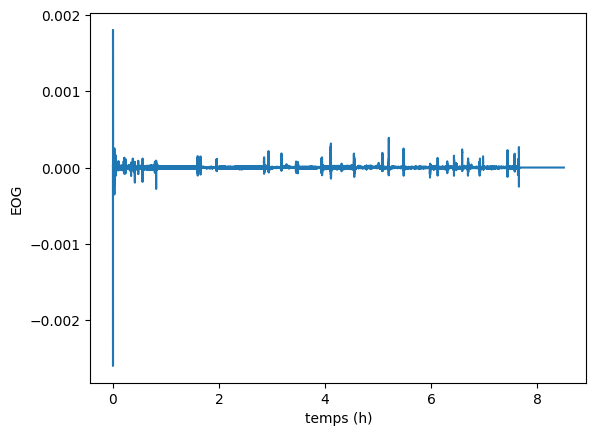

In [12]:
t=data.times
th = t/3600
eog = raw_data[3]
plt.plot(th,eog)
plt.ylabel("EOG")
plt.xlabel("temps (h)")

We can also look at the annotation:

In [13]:
# hypnogramme : on ajoute l'annotation à data

annot = mne.read_annotations(filename[1])
print(type(annot))
data.set_annotations(annot, emit_warning=True)
print(data.annotations[0]) 

for ann in data.annotations[:20]:
    descr = ann["description"]
    start = ann["onset"]
    end = ann["onset"] + ann["duration"]
    print("'{}' goes from {} to {}".format(descr, start, end))

<class 'mne.annotations.Annotations'>
OrderedDict([('onset', 0.0), ('duration', 630.0), ('description', 'Sleep stage W'), ('orig_time', datetime.datetime(1994, 9, 19, 0, 0, 30, tzinfo=datetime.timezone.utc))])
'Sleep stage W' goes from 0.0 to 630.0
'Sleep stage 1' goes from 630.0 to 750.0
'Sleep stage W' goes from 750.0 to 930.0
'Sleep stage 1' goes from 930.0 to 1080.0
'Sleep stage 2' goes from 1080.0 to 1230.0
'Sleep stage W' goes from 1230.0 to 1260.0
'Sleep stage 1' goes from 1260.0 to 1290.0
'Sleep stage 2' goes from 1290.0 to 1350.0
'Sleep stage 1' goes from 1350.0 to 1380.0
'Sleep stage 2' goes from 1380.0 to 1470.0
'Sleep stage W' goes from 1470.0 to 1500.0
'Sleep stage 1' goes from 1500.0 to 1530.0
'Sleep stage 2' goes from 1530.0 to 1710.0
'Sleep stage 1' goes from 1710.0 to 1740.0
'Sleep stage 2' goes from 1740.0 to 2010.0
'Sleep stage W' goes from 2010.0 to 2040.0
'Sleep stage 2' goes from 2040.0 to 2310.0
'Sleep stage 3' goes from 2310.0 to 2850.0
'Sleep stage 2' goes from

Using matplotlib as 2D backend.


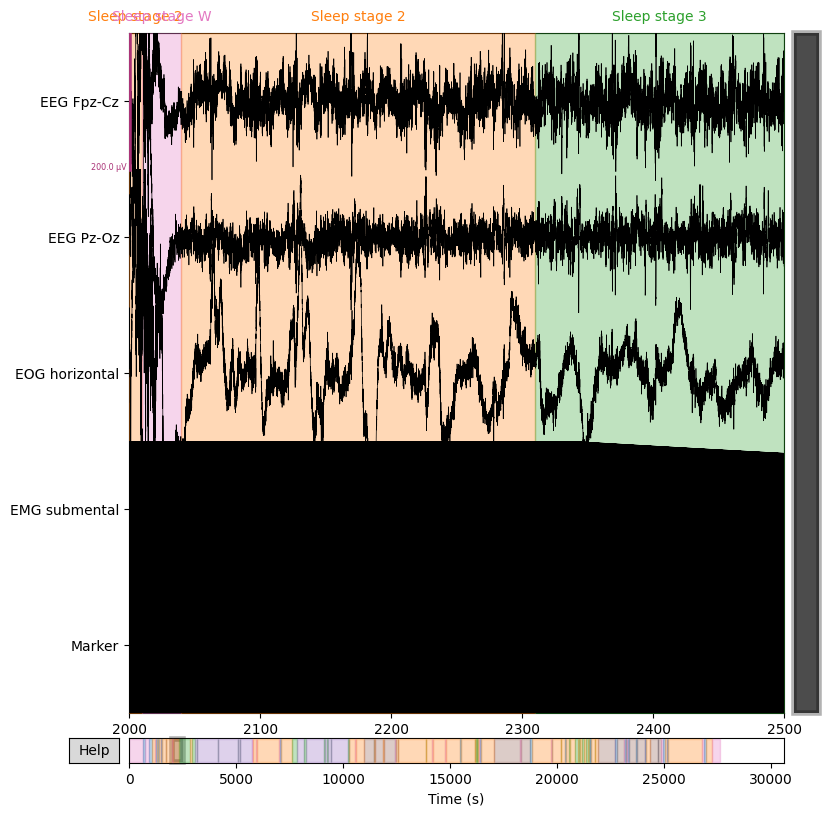

In [14]:
_ = data.plot(
    start=2000,
    duration=500,
    scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7, misc=1e-1),
)

Of course we can do the same for the Cassette study, and we can also directly use `matplotlib`. 

Extracting EDF parameters from C:\Users\EstebanPapacitoRico\Documents\GitHub\DL_Project\org-data\sleep-telemetry\ST7021J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3059999  =      0.000 ... 30599.990 secs...
*** type= <class 'numpy.ndarray'> , taille =  15300000 , dims =  (5, 3060000)
*** info : <Info | 8 non-empty values
 bads: []
 ch_names: EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal, EMG submental, Marker
 chs: 5 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 800.0 Hz
 meas_date: 1994-09-19 00:00:30 UTC
 nchan: 5
 projs: []
 sfreq: 100.0 Hz
 subject_info: 4 items (dict)
>
*** channels : ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental', 'Marker']


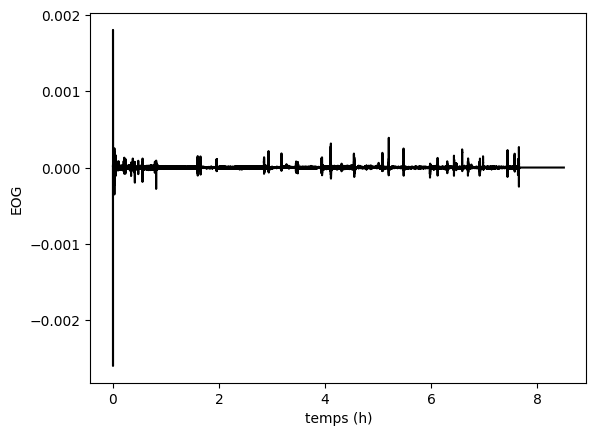

In [15]:
# PSG de cassette *
data = mne.io.read_raw_edf(filename[0], preload=True)
raw_data = data.get_data()
print("*** type=", type(raw_data), ", taille = ", raw_data.size, ", dims = ", raw_data.shape)
# you can get the metadata included in the file and a list of all channels:
print("*** info :", data.info)
print("*** channels :", data.ch_names)
t=data.times
th = t/3600
eog = raw_data[3]
_ = plt.plot(th,eog, 'k',)
_ = plt.ylabel("EOG")
_ = plt.xlabel("temps (h)")

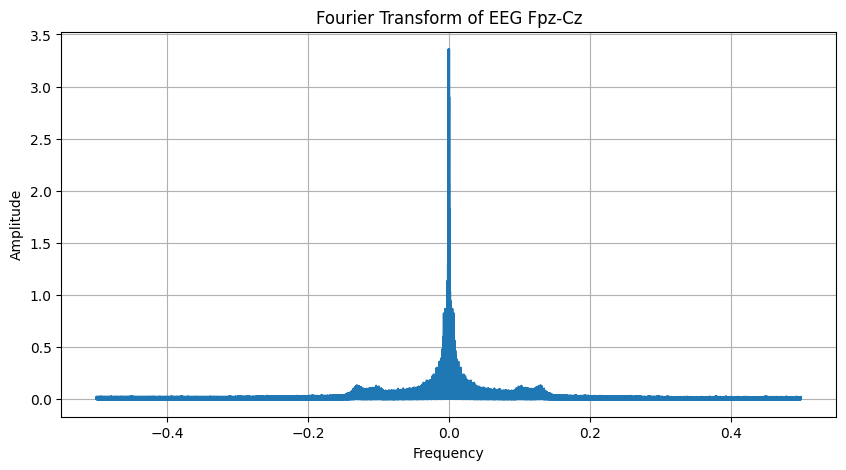

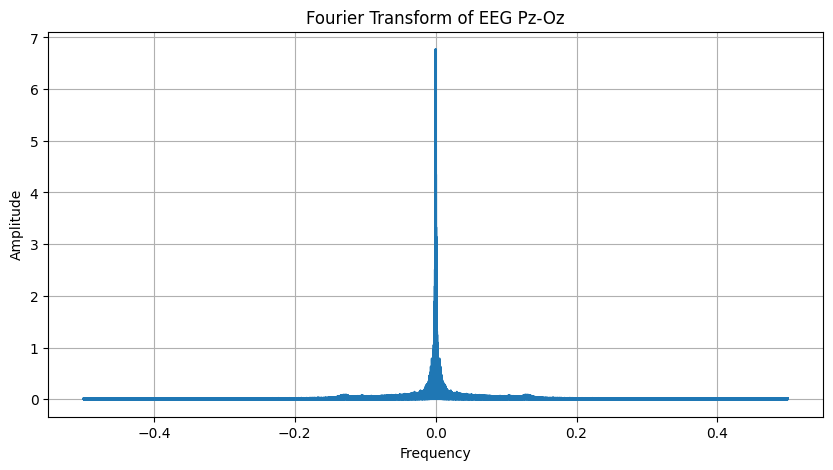

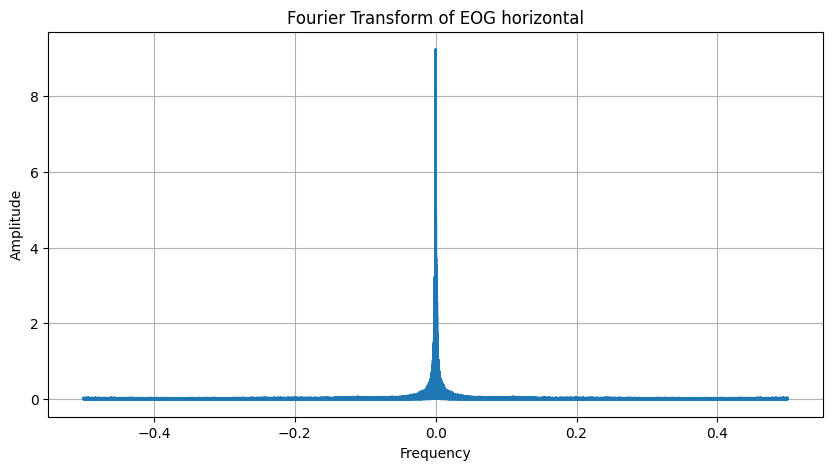

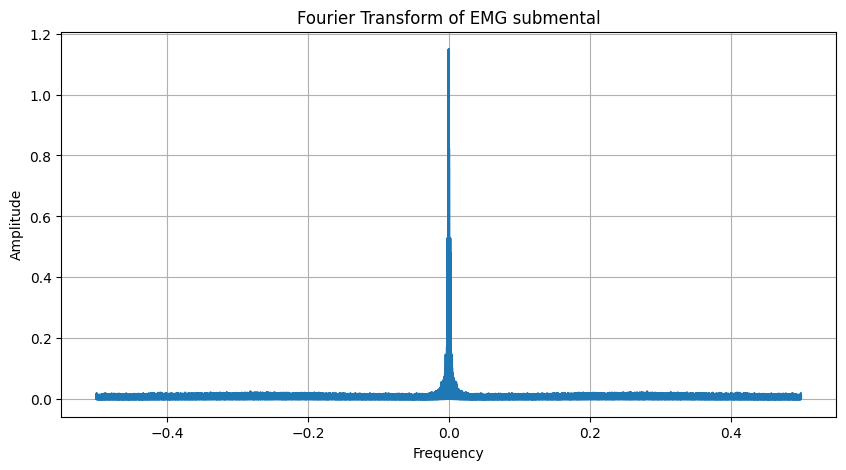

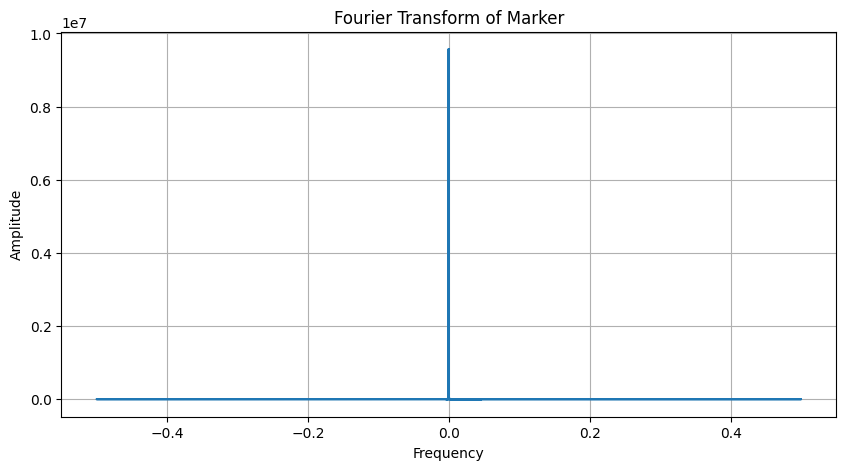

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Get the data and channel names
data_array, times = data[:]
channel_names = data.ch_names

# Define the scalings
scalings = dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7, misc=1e-1)

# For each channel
for i in range(data_array.shape[0]):
    # Compute Fourier Transform
    fourier_transform = np.fft.fft(data_array[i])
    frequencies = np.fft.fftfreq(len(data_array[i]))

    # Apply scaling
    fourier_transform = fourier_transform * scalings.get(channel_names[i], 1)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(frequencies, np.abs(fourier_transform))
    plt.title(f'Fourier Transform of {channel_names[i]}')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()